<a href="https://colab.research.google.com/github/mdl262/Colab-Projects/blob/main/examples/face_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Face_Landmarker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [10]:
import urllib.request

url = "https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task"
filename = 'face_landmarker_v2_with_blendshapes.task'

urllib.request.urlretrieve(url, filename)


('face_landmarker_v2_with_blendshapes.task',
 <http.client.HTTPMessage at 0x1d0acc7cfb0>)

## Visualization utilities

In [7]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

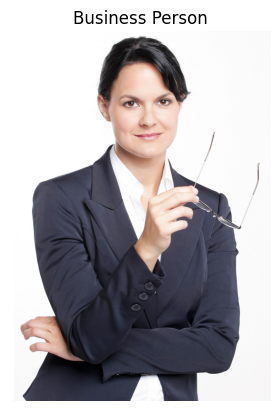

In [1]:
import urllib.request
import matplotlib.pyplot as plt
import cv2

url = "https://storage.googleapis.com/mediapipe-assets/business-person.png"
filename = 'image.png'

urllib.request.urlretrieve(url, filename)

img = cv2.imread("image.png")

# Convert the image from BGR (OpenCV default) to RGB (Matplotlib default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)
plt.title('Business Person')  # Add a title (optional)
plt.axis('off')  # Remove axis ticks and labels (optional)
plt.show()

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

We will also visualize the face blendshapes categories using a bar graph.

In [ ]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [ ]:
print(detection_result.facial_transformation_matrixes)